In [2]:
import itertools
import os
from collections import Counter
from typing import Optional
import random

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import Colormap
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from PIL import Image
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.environ['PYTHONHASHSEED'] = '0'
random.seed(1254)
tf.random.set_seed(2)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## EDA & Data processing

In [6]:
train_dir = os.path.join('/content/drive/MyDrive/images/train')
validation_dir = os.path.join('/content/drive/MyDrive/images/valid')
test_dir = os.path.join('/content/drive/MyDrive/images/test')

In [7]:
DATA_DIR = "/content/drive/MyDrive/images"
splits = ["train", "valid", "test"]

In [8]:
def collect_image_info(base_dir: str) -> np.ndarray:
    data = list()
    for split in splits:
        split_dir = os.path.join(base_dir, split)
        for label in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, label)
            if not os.path.isdir(class_dir):
                continue
            for fname in os.listdir(class_dir):
                fpath = os.path.join(class_dir, fname)
                try:
                    with Image.open(fpath) as img:
                        width, height = img.size
                        data.append({
                            "split": split,
                            "label": label,
                            "path": fpath,
                            "width": width,
                            "height": height,
                        })
                except Exception as e:
                    print(f"Error {fpath}: {e}")
    return pd.DataFrame(data)

In [9]:
df = collect_image_info(DATA_DIR)
print(df.head())
print("\nNumber of images per split and classes:")
print(df.groupby(["split", "label"]).size())

   split   label                                               path  width  \
0  train  Normal  /content/drive/MyDrive/images/train/Normal/Nor...    299   
1  train  Normal  /content/drive/MyDrive/images/train/Normal/Nor...    299   
2  train  Normal  /content/drive/MyDrive/images/train/Normal/Nor...    299   
3  train  Normal  /content/drive/MyDrive/images/train/Normal/Nor...    299   
4  train  Normal  /content/drive/MyDrive/images/train/Normal/Nor...    299   

   height  
0     299  
1     299  
2     299  
3     299  
4     299  

Number of images per split and classes:
split  label          
test   COVID               543
       Lung_Opacity        903
       Normal             1530
       Viral_Pneumonia     203
train  COVID              2531
       Lung_Opacity       4209
       Normal             7135
       Viral_Pneumonia     941
valid  COVID               542
       Lung_Opacity        901
       Normal             1528
       Viral_Pneumonia     201
dtype: int64


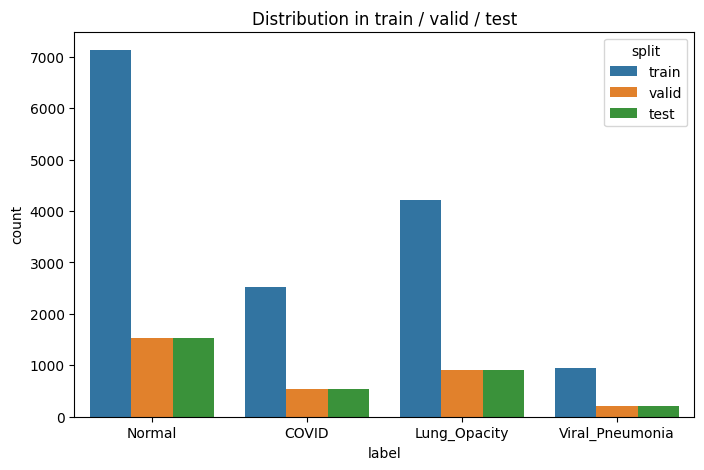

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="label", hue="split")
plt.title("Distribution in train / valid / test")
plt.show()

In [11]:
def show_examples(df: pd.DataFrame, n_per_class: int=3, split: str="training") -> None:
    subset = df[df["split"] == split]
    classes = subset["label"].unique()
    _, axes = plt.subplots(len(classes), n_per_class, figsize=(n_per_class * 3, len(classes) * 3))
    for i, label in enumerate(classes):
        sample_paths = subset[subset["label"] == label]["path"].sample(n_per_class)
        for j, path in enumerate(sample_paths):
            img = Image.open(path)
            ax = axes[i, j] if len(classes) > 1 else axes[j]
            ax.imshow(img, cmap='gray')
            ax.axis("off")
            if j == 0:
                ax.set_title(label)
    plt.suptitle(f"Samples from {split}-split")
    plt.tight_layout()
    plt.show()

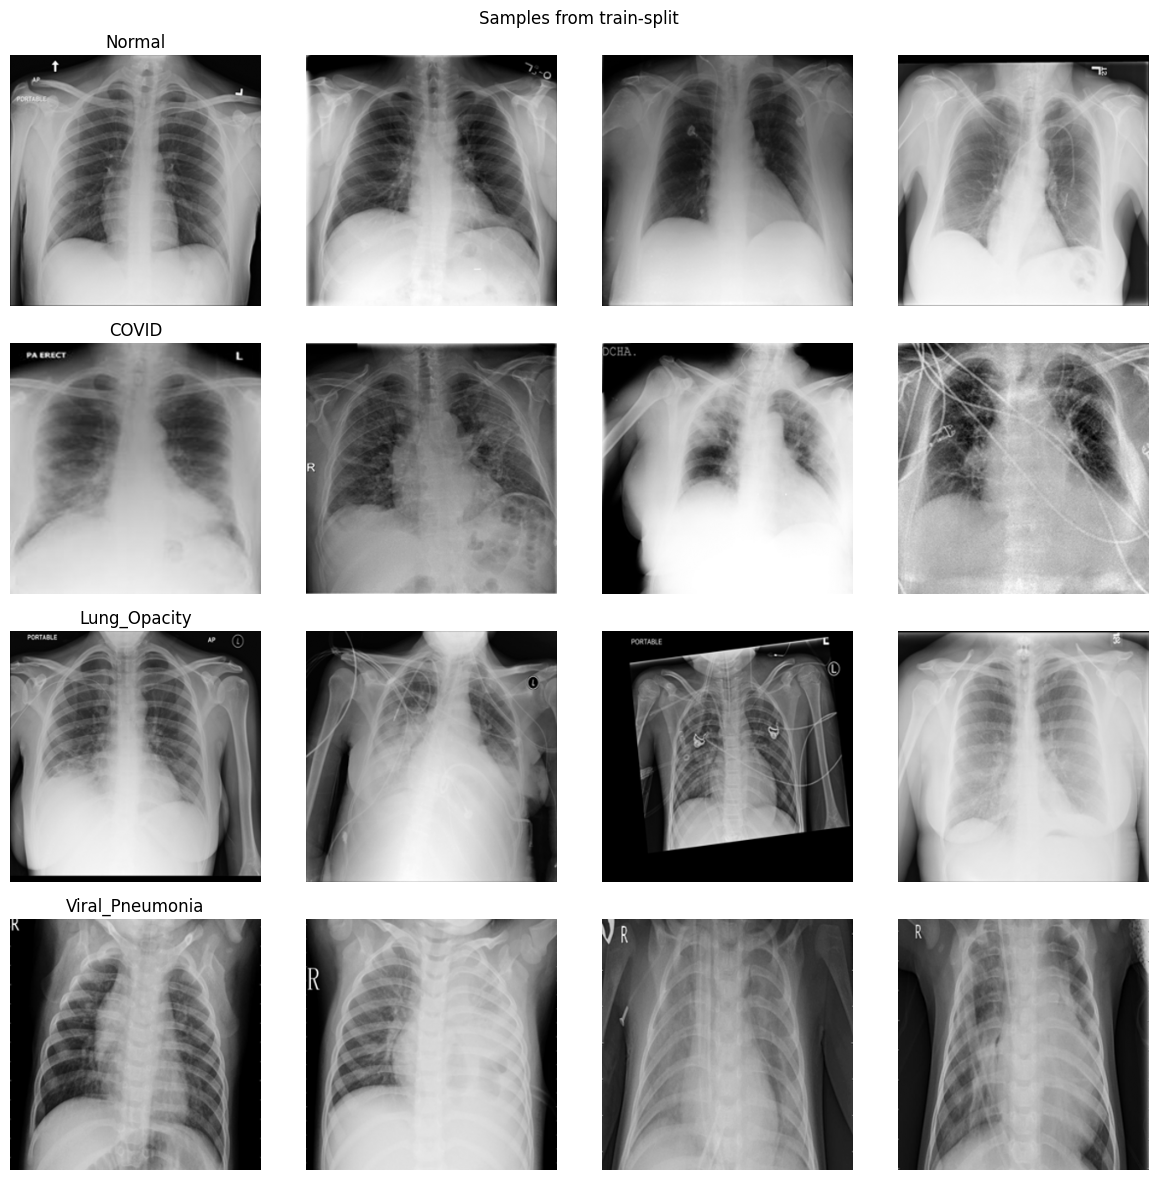

In [12]:
show_examples(df, n_per_class=4, split="train")

In [13]:
train_batches = ImageDataGenerator(
                preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                rotation_range=15,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
        )\
        .flow_from_directory(
                directory=train_dir,
                target_size=(224,224),
                classes=['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'],
                batch_size=16
        )

validation_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)\
        .flow_from_directory(
                directory=validation_dir,
                target_size=(224,224),
                classes=['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'],
                batch_size=16
        )

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)\
        .flow_from_directory(
                directory=test_dir,
                target_size=(224,224),
                classes=['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'],
                batch_size=1,
                shuffle=False
        )

Found 14816 images belonging to 4 classes.
Found 3172 images belonging to 4 classes.
Found 3179 images belonging to 4 classes.


## Model

In [14]:
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
out = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,122,500 (92.02 MB)

 Trainable params: 530,180 (2.02 MB)

 Non-trainable params: 23,592,320 (90.00 MB)

In [16]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=8
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/modles/DenseNet_model.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4)
]

In [17]:
def compile_model(model, lr=1e-3) -> Model:
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    metrics = [
        'accuracy',
        tf.keras.metrics.CosineSimilarity(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.AUC()
    ]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=metrics
    )
    return model

In [18]:
compile_model(model, lr=1e-3)

<Functional name=functional, built=True>

In [19]:
counter = Counter(train_batches.classes)
print(len(counter))
max_val = float(max(counter.values()))
print(max_val)
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
print(class_weights)

4
7135.0
{np.int32(0): 2.8190438561833266, np.int32(1): 1.695177001663103, np.int32(2): 1.0, np.int32(3): 7.582359192348565}


## Training

In [20]:
epochs = 20

history_ext = model.fit(
            x=train_batches,
            validation_data=validation_batches,
            epochs=epochs,
            verbose=1,
            callbacks=callbacks_list,
            class_weight=class_weights
        )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
926/926 ━━━━━━━━━━━━━━━━━━━━ 419s 428ms/step - accuracy: 0.5954 - auc: 0.8236 - cosine_similarity: 0.6641 - loss: 2.6046 - precision: 0.6378 - recall: 0.5385 - val_accuracy: 0.8370 - val_auc: 0.9589 - val_cosine_similarity: 0.8607 - val_loss: 1.1826 - val_precision: 0.8724 - val_recall: 0.7973 - learning_rate: 1.0000e-04
Epoch 2/20
926/926 ━━━━━━━━━━━━━━━━━━━━ 349s 376ms/step - accuracy: 0.7401 - auc: 0.9202 - cosine_similarity: 0.7872 - loss: 2.0168 - precision: 0.7822 - recall: 0.6888 - val_accuracy: 0.8439 - val_auc: 0.9624 - val_cosine_similarity: 0.8623 - val_loss: 1.1431 - val_precision: 0.8739 - val_recall: 0.7910 - learning_rate: 1.0000e-04
Epoch 3/20
926/926 ━━━━━━━━━━━━━━━━━━━━ 345s 373ms/step - accuracy: 0.7744 - auc: 0.9384 - cosine_similarity: 0.8145 - loss: 1.8771 - precision: 0.8153 - recall: 0.7273 - val_accuracy: 0.8723 - val_auc: 0.9727 - val_cosine_similarity: 0.8877 - val_loss: 1.0785 - val_precision: 0.9027 - val_recall: 0.8339 - learning_rate: 1.0000e-0

In [21]:
number_epochs = len(history_ext.history['loss'])

### Finetuning

In [22]:
for layer in model.layers[-100:]:
    layer.trainable = True

In [23]:
compile_model(model, lr=1e-4)

<Functional name=functional, built=True>

In [24]:
history_fine = model.fit(
                x=train_batches,
                validation_data=validation_batches,
                epochs=epochs,
                verbose=1,
                callbacks=callbacks_list,
                class_weight=class_weights
            )

Epoch 1/20
926/926 ━━━━━━━━━━━━━━━━━━━━ 407s 389ms/step - accuracy: 0.8196 - auc_1: 0.9571 - cosine_similarity: 0.8488 - loss: 1.4925 - precision_1: 0.8503 - recall_1: 0.7803 - val_accuracy: 0.9061 - val_auc_1: 0.9869 - val_cosine_similarity: 0.9208 - val_loss: 0.7749 - val_precision_1: 0.9185 - val_recall_1: 0.8912 - learning_rate: 1.0000e-04
Epoch 2/20
926/926 ━━━━━━━━━━━━━━━━━━━━ 355s 383ms/step - accuracy: 0.8816 - auc_1: 0.9785 - cosine_similarity: 0.8978 - loss: 1.2664 - precision_1: 0.9005 - recall_1: 0.8535 - val_accuracy: 0.8219 - val_auc_1: 0.9624 - val_cosine_similarity: 0.8544 - val_loss: 0.8900 - val_precision_1: 0.8572 - val_recall_1: 0.7796 - learning_rate: 1.0000e-04
Epoch 3/20
926/926 ━━━━━━━━━━━━━━━━━━━━ 347s 374ms/step - accuracy: 0.9016 - auc_1: 0.9834 - cosine_similarity: 0.9133 - loss: 1.1975 - precision_1: 0.9150 - recall_1: 0.8784 - val_accuracy: 0.9294 - val_auc_1: 0.9916 - val_cosine_similarity: 0.9375 - val_loss: 0.6908 - val_precision_1: 0.9401 - val_recall_

## Visualization

In [25]:
acc = history_ext.history['accuracy']
val_acc = history_ext.history['val_accuracy']
loss = history_ext.history['loss']
val_loss = history_ext.history['val_loss']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

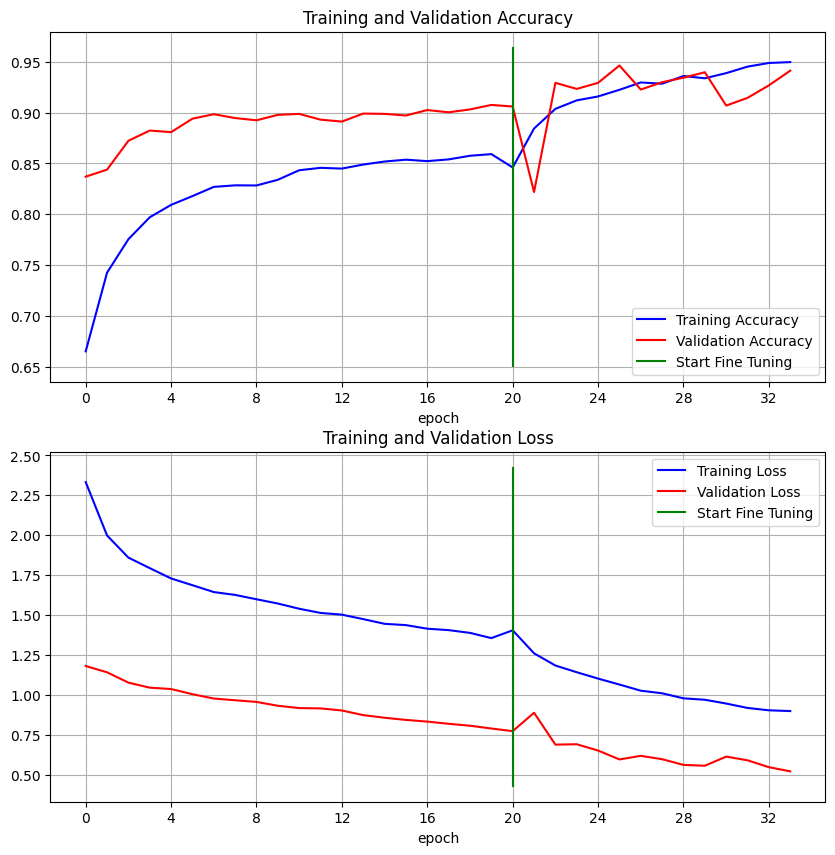

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, 'b-', label='Training Accuracy')
plt.plot(val_acc, 'r-', label='Validation Accuracy')
plt.plot([number_epochs, number_epochs], plt.ylim(), label='Start Fine Tuning', color='green')
plt.legend(loc='lower right', prop={'weight': 'normal'})
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(loss, 'b-', label='Training Loss')
plt.plot(val_loss, 'r-', label='Validation Loss')
plt.plot([number_epochs, number_epochs], plt.ylim(), label='Start Fine Tuning', color='green')
plt.legend(loc='upper right', prop={'weight': 'normal'})
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid(True)

In [27]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/modles/DenseNet_model.keras')
predictions = best_model.predict(x=test_batches, verbose=1)

3179/3179 ━━━━━━━━━━━━━━━━━━━━ 59s 17ms/step


In [28]:
def plot_confusion_matrix(
        cm: np.ndarray,
        classes: list[str],
        normalize: bool=True,
        title: str='Confusion Matrix',
        cmap: Optional[Colormap]=plt.cm.Blues
) -> None:
    plt.figure(figsize=(6, 6), facecolor='w', edgecolor='k')
    font = {
        'family': 'DejaVu Sans',
        'weight': 'bold',
        'size'  : 12
    }
    plt.rc('font', **font)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix without normalization')
    cm = np.around(cm, 4)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    print(cm)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center',
            color='white' if cm[i, j] > thresh else 'black')
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.tight_layout()
    plt.title(title)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=12)
    plt.savefig("/content/drive/MyDrive/images/results/confusion_matrix.png", bbox_inches="tight", pad_inches=0.2)
    plt.show()

Normalized Confusion Matrix
[[0.9595 0.0129 0.0184 0.0092]
 [0.0066 0.928  0.0653 0.    ]
 [0.0065 0.0333 0.9438 0.0163]
 [0.     0.     0.     1.    ]]


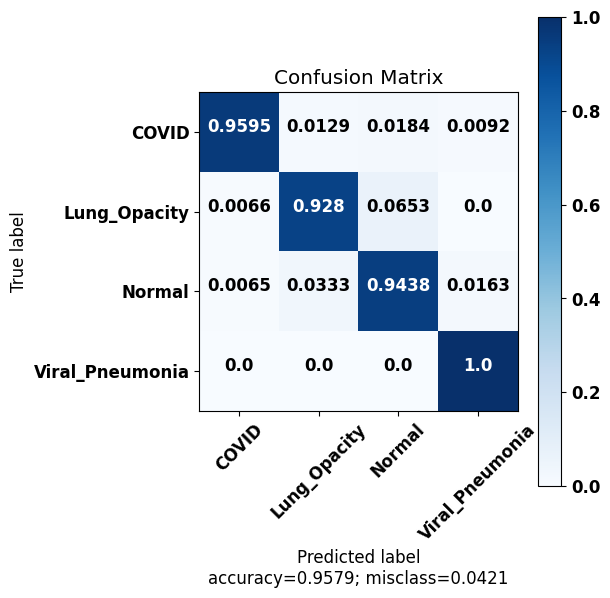

In [29]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = (['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [30]:
target_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
y_pred = np.argmax(predictions, axis=1)
print(classification_report(test_batches.classes, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

          COVID       0.97      0.96      0.96       543
   Lung_Opacity       0.94      0.93      0.93       903
         Normal       0.95      0.94      0.95      1530
Viral_Pneumonia       0.87      1.00      0.93       203

       accuracy                           0.95      3179
      macro avg       0.93      0.96      0.94      3179
   weighted avg       0.95      0.95      0.95      3179



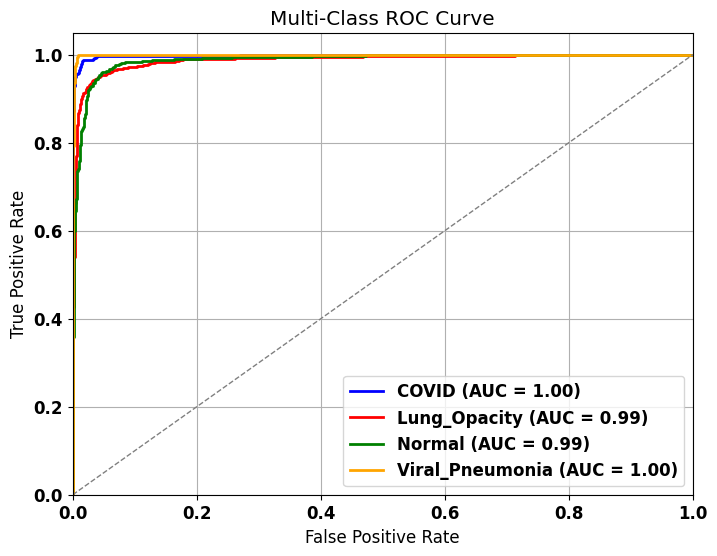

In [31]:
y_true = test_batches.classes
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
n_classes = y_true_bin.shape[1]

plt.figure(figsize=(8,6))
colors = ['blue', 'red', 'green', 'orange']
class_names = list(test_batches.class_indices.keys())

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label='{} (AUC = {:0.2f})'.format(class_names[i], roc_auc))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/images/results/ROC_curve.png", bbox_inches="tight", pad_inches=0.2)
plt.show()
